In [1]:
import laytr
import truvari
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

In [32]:
# The region output from `truvari refine`
region_fn = "../tests/gangstr_strawman/refine.regions.txt"
# The GIAB TR bed file (with annotations)
bed_fn = "../tests/tmp.delta.bed.gz"
# The Adotto full TR catalog
tr_catalog_fn = "/Users/english/code/adotto/regions/adotto_TRregions_v1.1.bed"

In [3]:
regions = pd.read_csv(region_fn, sep='\t')
bed = pd.read_csv(bed_fn, sep='\t', 
                  names=["chrom", "start", "end", "tier", "replicates", "var_flag", "entropy", "ad1", "ad2"])

In [4]:
# Helper methods

def region_stats(data):
    result = {}
    base = (data['out_tpbase'] != 0) | (data['out_fn'] != 0)
    baseP = int(base.sum())
    baseN = int((~base).sum())
    comp = (data['out_tp'] != 0) | (data['out_fp'] != 0)
    compP = int(comp.sum())
    compN = int((~comp).sum())
    
    state_cnts = data['state'].value_counts()
    result["TP"] = state_cnts["TP"] if "TP" in state_cnts else 0
    result["TN"] = state_cnts["TN"] if "TN" in state_cnts else 0
    
    fpfn = state_cnts["FN,FP"] if "FN,FP" in state_cnts else 0
    result["FP"] = fpfn + (state_cnts["FP"] if "FP" in state_cnts else 0)
    result["FN"] = fpfn + (state_cnts["FN"] if "FN" in state_cnts else 0)

    result["base P"] = baseP
    result["base N"] = baseN
    result["comp P"] = compP
    result["comp N"] = compN
    # precision
    result["PPV"] = result["TP"] / result["comp P"] if result["comp P"] != 0 else None
    # recall
    result["TPR"] = result["TP"] / result["base P"] if result["base P"] != 0 else None
    # specificity
    result["TNR"] = result["TN"] / result["base N"] if result["base N"] != 0 else None
    # negative predictive value
    result["NPV"] = result["TN"] / result["comp N"] if result["comp N"] != 0 else None
    # accuracy
    if result["base P"] + result["base N"] != 0:
        result["ACC"] = (result["TP"] + result["TN"]) / (result["base P"] + result["base N"])
    else:
        result["ACC"] = None
    if result["TPR"] is not None and result["TNR"] is not None:
        result["BA"] = (result["TPR"] + result["TNR"]) / 2
    else:
        result["BA"] = None

    if result["PPV"] and result["TPR"]:
        result["F1"] = 2 * ((result["PPV"] * result["TPR"]) / (result["PPV"] + result["TPR"]))
    else:
        result["F1"] = None
    return result

def get_expcon(x):
    if x['ad1'] == 0 and x['ad2'] == 0:
        return "REF"
    if x['ad1'] <= 0 and x['ad2'] <= 0:
        return "CON"
    if x['ad1'] >= 0 and x['ad2'] >= 0:
        return "EXP"
    return "MIX"

def get_maxadbin(x):
    sz = max(abs(x['ad1']), abs(x['ad2']))
    return truvari.get_sizebin(sz)

def make_recm_report(data):
    names = []
    rows = []
    for recm, sub in data.groupby('exp/con'):
        names.append(recm)
        rows.append(region_stats(sub))
    return pd.DataFrame(rows, index=pd.Index(names, name="ExpCon"))

def make_perf_by_max_entropy(data):
    ba_by_ent_min = []
    ba_by_ent = []
    for i in range(0, 100, 2):
        i /= 100
        sub = region_stats(data[data['entropy'] <= i])
        ba_by_ent_min.append(i)
        ba_by_ent.append(sub)
    return pd.DataFrame(ba_by_ent, index=pd.Index(ba_by_ent_min, name="Max Entropy"))

def make_perf_by_entropy_bin(data):
    names = []
    rows = []
    for idx, sub in data.groupby('entropy_bin'):
        names.append(idx)
        rows.append(region_stats(sub))
    return pd.DataFrame(rows, index=pd.Index(names, name="Entropy Bin"))

def make_perf_by_mxszbin(data):
    names = []
    rows = []
    for idx, sub in data.groupby('mx_szbin'):
        names.append(idx)
        rows.append(region_stats(sub))
    mxszbin_report = pd.DataFrame(rows, index=pd.Series(names).astype(truvari.SZBINTYPE)).loc[truvari.SZBINS]
    return mxszbin_report

In [5]:
bed.set_index(["chrom", "start", "end"], inplace=True)
regions.set_index(["chrom", "start", "end"], inplace=True)

data = regions.join(bed)
data['exp/con'] = data.apply(get_expcon, axis=1)
data['mx_szbin'] = data.apply(get_maxadbin, axis=1)
data['entropy_bin'] = pd.cut(data['entropy'], bins=[0, 0.25, 0.50, 0.60, 0.70, 0.80, 0.90, 1], right=True)

# Reports by Benchmark subsets

Let's start by looking at the overall by-region performance of the tool as well as subsets of the benchmark. The subsets are:
- Full : All GIABTR regions
- Tier1/2 : Performance on Tier subsets of regions 
- AnyVar : Performance on regions which had any variation observed across Adotto pVCF

In [6]:
full_report = region_stats(data)
t1_report = region_stats(data[data["tier"] == "Tier1"])
t2_report = region_stats(data[data["tier"] == "Tier2"])
any_var_report = region_stats(data[data["var_flag"] != 0])

sub_reports = pd.DataFrame([full_report, t1_report, t2_report, any_var_report], 
                           index=pd.Index(["Full", "Tier1", "Tier2", "AnyVar"], name="Subset"))
sub_reports

,TP,TN,FP,FN,base P,base N,comp P,comp N,PPV,TPR,TNR,NPV,ACC,BA,F1
Subset,,,,,,,,,,,,,,,
Full,32510,1598495,5270,72330,105208,1601645,39076,1667777,0.831968,0.309007,0.998033,0.958458,0.955563,0.653520,0.450639
Tier1,31273,1595206,4765,70433,101972,1598203,37225,1662950,0.840107,0.306682,0.998125,0.959263,0.956654,0.652403,0.449334
Tier2,1237,3289,505,1897,3236,3442,1851,4827,0.668287,0.382262,0.955549,0.681376,0.677748,0.668906,0.486338
AnyVar,32509,1118225,5229,72325,105202,1121334,39034,1187502,0.832838,0.309015,0.997227,0.941662,0.938198,0.653121,0.450775


# RECM Report

The GIABTR bed file holds information about the allele length deltas per-haplotype. These deltas are calculated as the sum of variant lengths in HG002 per-haplotype. For example, if the first haplotype has two 10bp deletions, the allele delta is -20bp. 

We can use these deltas to annotate TR regions as being EXPansions or CONtractions of the reference allele. 

Some regions may also have REFerence length, where the delta is 0. Most of these are simply invariant sites in HG002 or those that only contain SNPs but also includes 'balanced' variants. For example, a haplotype with a 5bp DEL and 5bp INS has a 0bp allele delta and would be classified as "REF".

Because the GIABTR bed file has allele length deltas per-haplotype, it's possible that haplotype1 has an EXPansion while haplotype2 has a CONtractions. These are annotated as MIXed.

Below is the Reference Expansion Contraction Mix report (recm):

In [9]:
recm_report = make_recm_report(data)
recm_report

,TP,TN,FP,FN,base P,base N,comp P,comp N,PPV,TPR,TNR,NPV,ACC,BA,F1
ExpCon,,,,,,,,,,,,,,,
CON,14603,93964,2333,33409,48203,95208,17581,125830,0.830613,0.302948,0.986934,0.746754,0.757034,0.644941,0.443968
EXP,14090,91947,2066,29996,44241,93277,16540,120978,0.851874,0.318483,0.985741,0.760031,0.771077,0.652112,0.463632
MIX,3783,9095,432,8826,12630,9239,4469,17400,0.846498,0.299525,0.984414,0.522701,0.588870,0.641969,0.442482
REF,34,1403489,439,99,134,1403921,486,1403569,0.069959,0.253731,0.999692,0.999943,0.999621,0.626712,0.109677


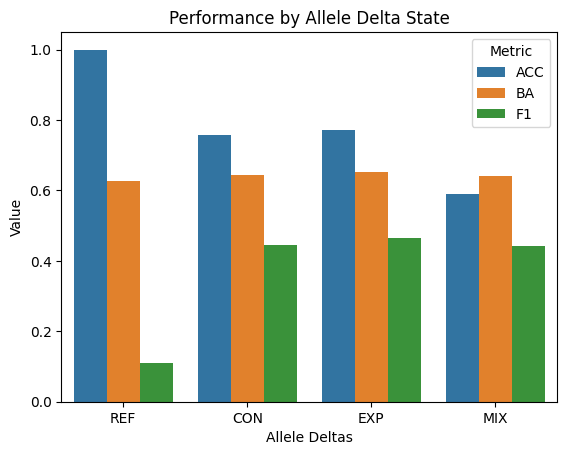

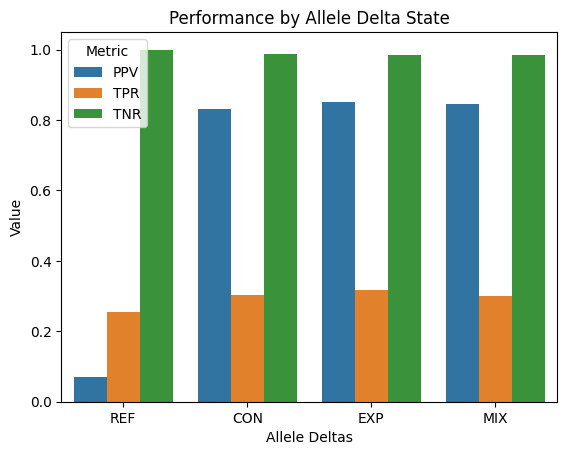

In [11]:
view = (recm_report.melt(ignore_index=False, 
                        value_vars=["ACC", "BA", "F1"], 
                        var_name="Metric", 
                        value_name='Value')
            .reset_index())
p = sb.barplot(data=view, 
               x="ExpCon", 
               y="Value", 
               hue="Metric",
               order=["REF", "CON", "EXP", "MIX"])
_ = p.set(title="Performance by Allele Delta State", xlabel="Allele Deltas")
plt.show()

view = (recm_report.melt(ignore_index=False, 
                        value_vars=["PPV", "TPR", "TNR"], 
                        var_name="Metric", 
                        value_name='Value')
            .reset_index())
p = sb.barplot(data=view, 
               x="ExpCon", 
               y="Value", 
               hue="Metric",
               order=["REF", "CON", "EXP", "MIX"])
_ = p.set(title="Performance by Allele Delta State", xlabel="Allele Deltas")

# Entropy

The GIABTR bed file holds information about the reference sequence entropy over regions. As the entropy lowers, the sequence has less nucleotide diversity (e.g. an entropy of 0 would be a pure homopolymer regions). We can use this entropy as a proxy for describing the difficulty of resolving the region.

To calculate the performance by max entropy, we iteratively subset the caller's region performance for all regions with entropy <= a range of entropy steps. 

We expect to see an increase in the performance of regions at an entropy range where a tool begins to give better results. This gives us an idea of a minimum sequence complexity before a tool becomes reliable.

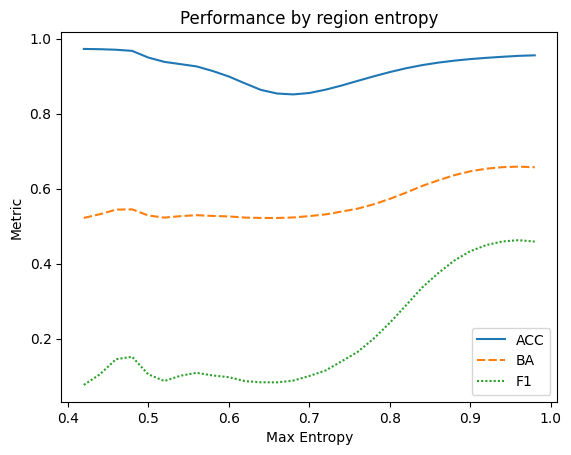

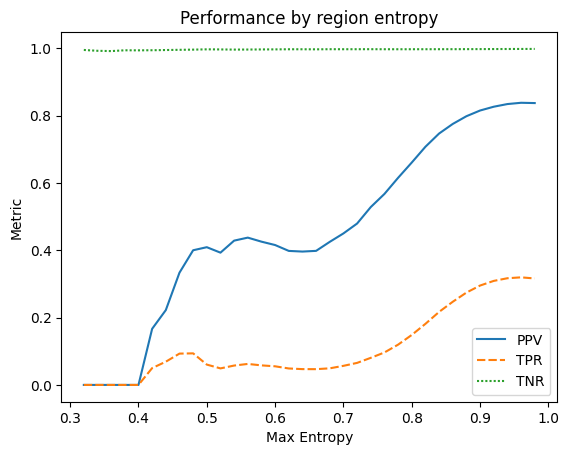

In [12]:
max_entropy = make_perf_by_max_entropy(data)

p = sb.lineplot(data=max_entropy[["ACC", "BA", "F1"]].dropna())
_ = p.set(title="Performance by region entropy", ylabel="Metric")
plt.show()


p = sb.lineplot(data=max_entropy[["PPV", "TPR", "TNR"]].dropna())
_ = p.set(title="Performance by region entropy", ylabel="Metric")
plt.show()

If you're interested in a discrete-X view of the same information, we can cut the regions' entropy into bins

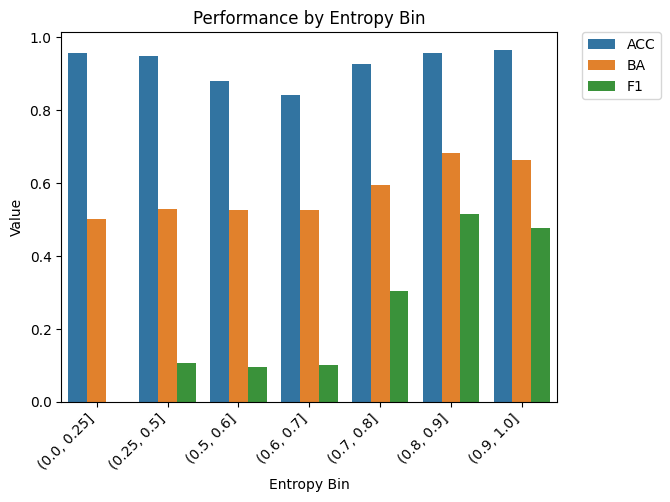

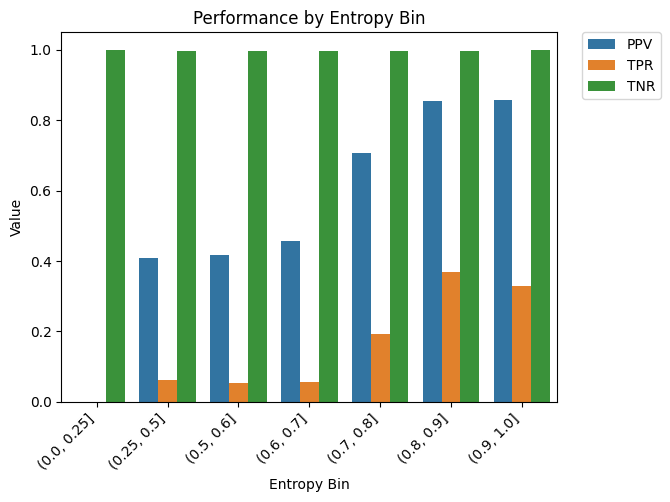

In [17]:
entropy_bin_report = make_perf_by_entropy_bin(data)

view = (entropy_bin_report.melt(ignore_index=False, 
                        value_vars=["ACC", "BA", "F1"], 
                        var_name="Metric", 
                        value_name='Value')
            .reset_index())
p = sb.barplot(data=view, 
               x="Entropy Bin", 
               y="Value", 
               hue="Metric")
_ = p.set(title="Performance by Entropy Bin")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xticks(rotation=45, ha='right')
plt.show()

view = (entropy_bin_report.melt(ignore_index=False, 
                        value_vars=["PPV", "TPR", "TNR"], 
                        var_name="Metric", 
                        value_name='Value')
            .reset_index())
p = sb.barplot(data=view, 
               x="Entropy Bin", 
               y="Value", 
               hue="Metric")
_ = p.set(title="Performance by Entropy Bin")
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()



# Max SizeBins

As described above in the RECM section, we have allele deltas. One interesting view of our data would be to separate by the size of the allele_delta. Here, we'll use Truvari's size bins and annotate each region's maximum allele delta into a categorical variable. 

Note that the 'SNP' size bin is allele_delta of 0, which may mean no variant in HG002, only SNPs, or balanced INS/DEL changes.

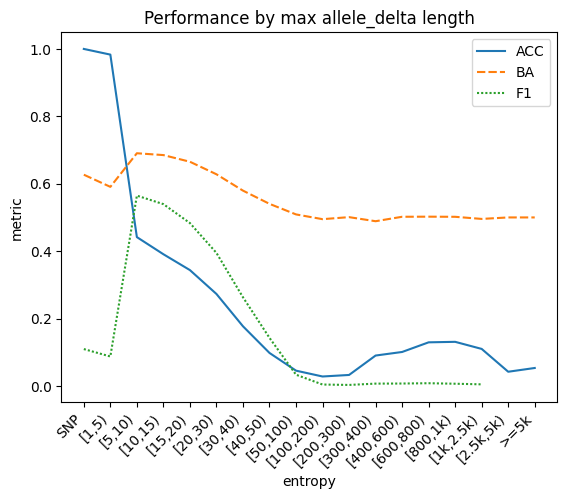

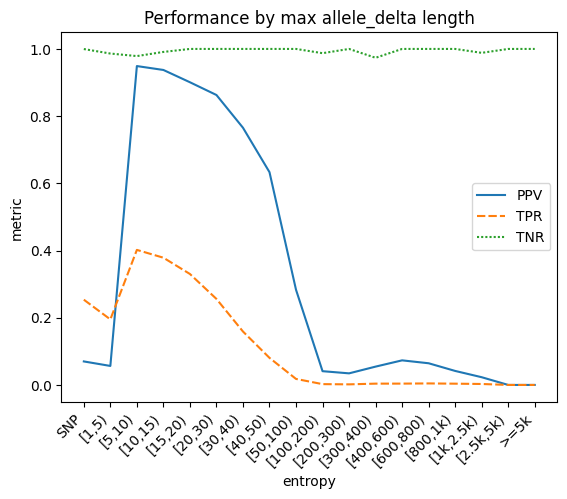

In [14]:
mxszbin_report = make_perf_by_mxszbin(data)

p = sb.lineplot(data=mxszbin_report[["ACC", "BA", "F1"]])
plt.xticks(rotation=45, ha='right')
_ = p.set(title="Performance by max allele_delta length", xlabel="entropy", ylabel="metric")
plt.show()

p = sb.lineplot(data=mxszbin_report[["PPV", "TPR", "TNR"]])
plt.xticks(rotation=45, ha='right')
_ = p.set(title="Performance by max allele_delta length", xlabel="entropy", ylabel="metric")

# Variant Flag

Included in the GIABTR bed is a 'var_flag' which encodes the variation observed in not only the HG002 sample, but 77 other haplotype resolved long read assemblies. We've already used the var_flag to look at the performance of regions with any observed variation (var_flag != 0) above.

The flags are defined as:
- 1 : An HG002 variant >=5bp
- 2 : An HG002 variant between SNP and up to 5bp
- 4 : A variant in another sample >= 5bp
- 8 : A variant in another sample between SNP up to 5bp

Let's look at the region performance for only loci with at least one >=5bp variant and add that to the `sub_reports`

In [28]:
subset = data[(data['var_flag'] & 1 != 0) | (data['var_flag'] & 4 != 0)]

sub_reports.loc['>=5'] = pd.Series(region_stats(subset))
sub_reports

,TP,TN,FP,FN,base P,base N,comp P,comp N,PPV,TPR,TNR,NPV,ACC,BA,F1
Subset,,,,,,,,,,,,,,,
Full,32510.0,1598495.0,5270.0,72330.0,105208.0,1601645.0,39076.0,1667777.0,0.831968,0.309007,0.998033,0.958458,0.955563,0.653520,0.450639
Tier1,31273.0,1595206.0,4765.0,70433.0,101972.0,1598203.0,37225.0,1662950.0,0.840107,0.306682,0.998125,0.959263,0.956654,0.652403,0.449334
Tier2,1237.0,3289.0,505.0,1897.0,3236.0,3442.0,1851.0,4827.0,0.668287,0.382262,0.955549,0.681376,0.677748,0.668906,0.486338
AnyVar,32509.0,1118225.0,5229.0,72325.0,105202.0,1121334.0,39034.0,1187502.0,0.832838,0.309015,0.997227,0.941662,0.938198,0.653121,0.450775
>=5,32489.0,194713.0,3394.0,72276.0,105133.0,195992.0,37168.0,263957.0,0.874112,0.309028,0.993474,0.737669,0.754511,0.651251,0.456624


For our example data, we see that the subsets have pretty much the same Negative Predictive Value and ACCuracy except for Tier2 and >= 5. 

NPV is `(TN / (TN+FN))` and ACC is `(TP + TN) / (TP + TN + FP + FN)`. Therefore, we can see that these two metrics are sensitive to a lot of Negative regions such that the metrics will always be high when there are many regions without variants.

By calculating the region performance on the subset with >=5bp variants, we're challenging the tool by removing regions which have simplier (easier) sequence differences across samples.

This example also explains why the Balanced Accuracy (`(TPR + TNR) / 2`) is typically more informative for imbalanced data (many more negatives than positives).

# TR Catalog annotations
With the exception of entropy, the GIABTR benchmark bed holds annotations that are specific to HG002 (and the pVCF). We can also intersect our benchmarked regions with the Adotto TRcatalog to get access to more reference information about each of the regions

In [33]:
catalog = (pd.read_csv(tr_catalog_fn, sep='\t')
               .rename(columns={'chr':"chrom"})
               .set_index(["chrom", "start", "end"]))
big_data = data.join(catalog)

# Gene TRs

To start, we'll look at the performance of our caller in TR regions that intersect with Genes

In [55]:
no_gene = region_stats(big_data[big_data['gene_flag'] == 0])
any_gene = region_stats(big_data[big_data['gene_flag'] != 0])
prot_gene = region_stats(big_data[big_data['biotype'].str.contains("protein")])

gene_report = pd.DataFrame([no_gene, any_gene, prot_gene], 
                           index=pd.Index(["Intergenic", "Genic", "Protein Coding Gene"], name="Subset"))
gene_report

,TP,TN,FP,FN,base P,base N,comp P,comp N,PPV,TPR,TNR,NPV,ACC,BA,F1
Subset,,,,,,,,,,,,,,,
Intergenic,12771,597055,2044,28825,41724,598303,15328,624699,0.833181,0.306083,0.997914,0.955748,0.952813,0.651998,0.447697
Genic,19739,1001440,3226,43505,63484,1003342,23748,1043078,0.831186,0.310929,0.998104,0.960082,0.957212,0.654517,0.452563
Protein Coding Gene,14612,758334,2404,32142,46928,759759,17582,789105,0.831077,0.311371,0.998124,0.961005,0.958173,0.654748,0.453015


# Interspersed Repeats

Some of the tandem repeats can be annotated as having interspersed repeats (e.g. ALUs) in the reference sequence. This is most often because a tandemly duplicated ALU in the reference can be picked up on by TandemRepeatFinder as being a tandem repeat. While this is technically a tandem repeat, one may not be interested in these kinds of events. Therefore, we'll make a report on the performance with respect to Interspersed repeats

In [39]:
no_inter = region_stats(big_data[big_data['interspersed'] == '.'])
has_inter = region_stats(big_data[big_data['interspersed'] != '.'])

inter_report = pd.DataFrame([no_inter, has_inter], 
                           index=pd.Index(["No Interspersed", "Interspersed"], name="Subset"))
inter_report

,TP,TN,FP,FN,base P,base N,comp P,comp N,PPV,TPR,TNR,NPV,ACC,BA,F1
Subset,,,,,,,,,,,,,,,
No Interspersed,30798,1516098,4788,65781,96908,1518967,36687,1579188,0.839480,0.317807,0.998111,0.960049,0.957312,0.657959,0.461065
Interspersed,1712,82397,482,6549,8300,82678,2389,88589,0.716618,0.206265,0.996601,0.930104,0.924498,0.601433,0.320329


# Repeat complexity

There are three columns inside the TR catalog that approximately describe the complexity:
- ovl_flag : a bit flag describing how TRF annotations overlap
- n_annos : the number of TRF annotatios in the regions
- n_subregions : the number of distinct non-overlapping subsets of annotations are in the regions.

*More details ... somewhere*

Let's build a report based on 'simple' vs 'complex' repeats.

In [43]:
# Regions with a single isolated annotation are typically the easiest
simple_overlap = (big_data["ovl_flag"] == 1) & (big_data["n_subregions"] == 1)

# Regions with a single parent/nested annotations are next
parent_overlap = (big_data["ovl_flag"].isin([2, 4, 6])) & (big_data["n_subregions"] == 1)

# We'll consider the rest of the overlaps as being 'complex'
cpx_overlap = ~simple_overlap & ~parent_overlap

# Regions with multiple annotations or multiple sub-regions are typically difficult
multi_anno = big_data["n_annos"] >= 2
multi_subreg = big_data["n_subregions"] >= 2

# The above subsets are boolean masks. We can use list comprehension to 
# run each subset through `region_stats` and put them all together 
results = [region_stats(big_data[_]) for _ in [simple_overlap,
                                               parent_overlap,
                                               cpx_overlap,
                                               multi_anno,
                                               multi_subreg]]
cpx_report = pd.DataFrame(results, 
                           index=pd.Index(["Simple Overlap", "Parent Overlap", "Complex Overlap", "Multi Anno", "Multi SubReg"],
                           name="Subset"))
cpx_report

,TP,TN,FP,FN,base P,base N,comp P,comp N,PPV,TPR,TNR,NPV,ACC,BA,F1
Subset,,,,,,,,,,,,,,,
Simple Overlap,19001,823006,2409,22856,42042,824544,21838,844748,0.870089,0.451953,0.998135,0.974262,0.971637,0.725044,0.594897
Parent Overlap,1295,291669,757,13125,14444,292135,2183,304396,0.593220,0.089657,0.998405,0.958189,0.955591,0.544031,0.155771
Complex Overlap,12214,483820,2104,36349,48722,484966,15055,518633,0.811292,0.250688,0.997637,0.932875,0.929446,0.624162,0.383022
Multi Anno,12283,519274,2193,38706,51155,520437,15226,556366,0.806712,0.240113,0.997765,0.933332,0.929959,0.618939,0.370076
Multi SubReg,11671,437586,1936,33375,45198,438639,14297,469540,0.816325,0.258219,0.997599,0.931946,0.928530,0.627909,0.392335


# Motif length

The TR catalog has a column 'annos' with json of TandemRepeatFinder hits over the region. We can therefore calculate the maximum motif length of each region and use that as a way to stratify the caller's performance.

In [45]:
import sys
import json
def get_max_motif_length(row):
    data = json.loads(row['annos'])
    return max([anno['period'] for anno in data])
big_data['max_motif'] = big_data.apply(get_max_motif_length, axis=1)

In [50]:
big_data['max_motif_bin'] = pd.cut(big_data["max_motif"], bins=[0, 5, 10, 20, 50, sys.maxsize], right=True,
                                   labels=["<5", "[5,10)", "[10, 20)", "[20, 50)", ">=50"])

names = []
rows = []
for mbin, subset in big_data.groupby("max_motif_bin"):
    names.append(mbin)
    rows.append(region_stats(subset))
motif_report = pd.DataFrame(rows, index=pd.Index(names, name="Motif Length Bin"))
motif_report

,TP,TN,FP,FN,base P,base N,comp P,comp N,PPV,TPR,TNR,NPV,ACC,BA,F1
Motif Length Bin,,,,,,,,,,,,,,,
<5,24873,788862,3009,31920,57040,790728,28520,819248,0.872125,0.436062,0.997640,0.962910,0.959856,0.716851,0.581417
"[5,10)",4399,345231,934,12439,16883,345844,5563,357164,0.790760,0.260558,0.998228,0.966590,0.963893,0.629393,0.391963
"[10, 20)",2028,290294,681,11042,13101,290706,2885,300922,0.702946,0.154797,0.998583,0.964682,0.962196,0.576690,0.253722
"[20, 50)",517,117576,302,10264,10798,117682,960,127520,0.538542,0.047879,0.999099,0.922020,0.919155,0.523489,0.087940
>=50,693,56532,344,6665,7386,56685,1148,62923,0.603659,0.093826,0.997301,0.898431,0.893150,0.545564,0.162409


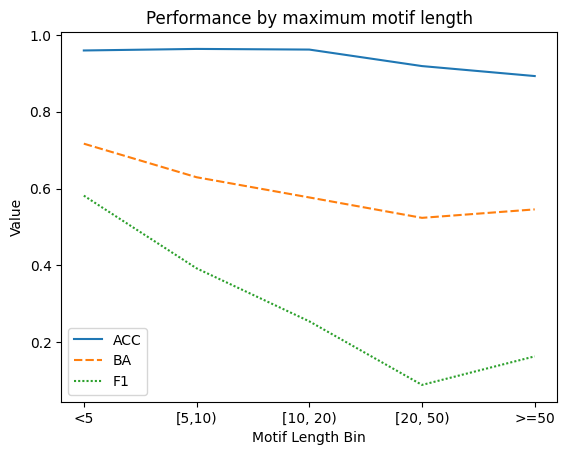

In [54]:
p = sb.lineplot(data=motif_report[["ACC", "BA", "F1"]])
_ = p.set(title="Performance by maximum motif length", ylabel="Value")

# Self Organizing Maps

Part of the laytr package is Self Organizing Maps (SOMs), including a SOM made on the kmer-featurization of the sequence spanned by tandem repeats. An interesting analysis of the region performance would be to see if there's differences in e.g. the balanced accuracy of the tool depending on the sequence context.

In [60]:
import joblib
som_map = joblib.load("../soms/adotto_TRr_kfeats_3mers.map")
som_map_df = pd.DataFrame(som_map['map'], 
                          index=pd.MultiIndex.from_tuples(som_map['index'], names=["chrom", "start", "end"]),
                          columns=['neuron_x', 'neuron_y'])

In [61]:
bigger_data = big_data.join(som_map_df)

In [62]:
index = []
rows = []
for neuron, subset in bigger_data.groupby(["neuron_x", "neuron_y"]):
    index.append(neuron)
    rows.append(region_stats(subset))

In [76]:
neuron_report = pd.DataFrame(rows, index=pd.Index(index))

In [97]:
import numpy as np

def make_hue_matrix(data, column):
    ret = np.empty((25, 25))

    for idx, row in data.iterrows():
        ret[idx] = row[column]
    return ret

In [98]:
ba_matrix = make_hue_matrix(neuron_report, "BA")
acc_matrix = make_hue_matrix(neuron_report, "ACC")
f1_matrix = make_hue_matrix(neuron_report, "F1")

In [94]:
som = joblib.load("../soms/adotto_TRv1.1_3mers.som")

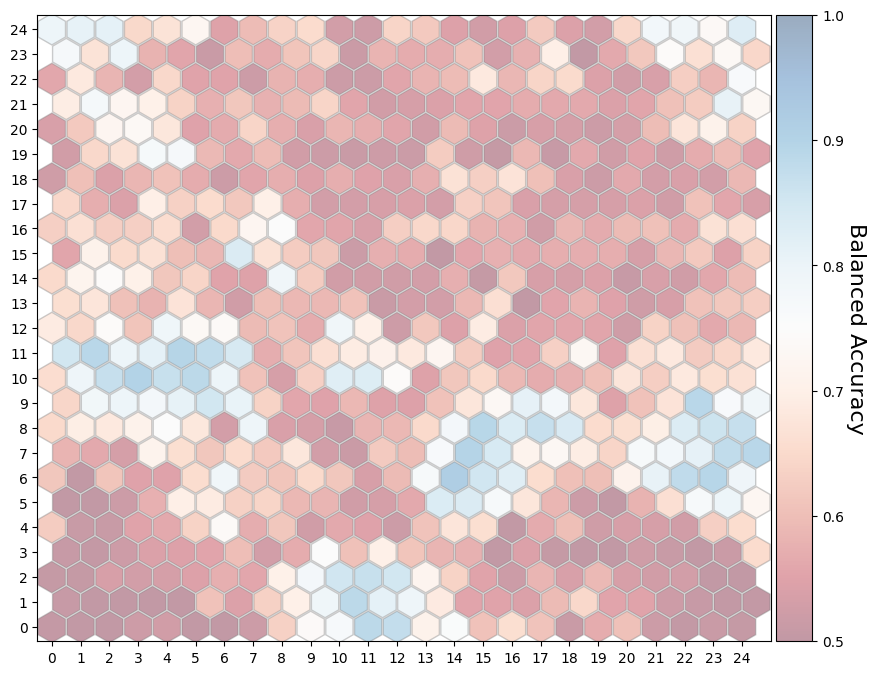

In [99]:
from matplotlib import colors, cm

norm = colors.Normalize(vmin=0.50, vmax=1.00)
p = laytr.make_hex_plot(som, hue=ba_matrix, hue_label="Balanced Accuracy", color_map=cm.RdBu, color_norm=norm)

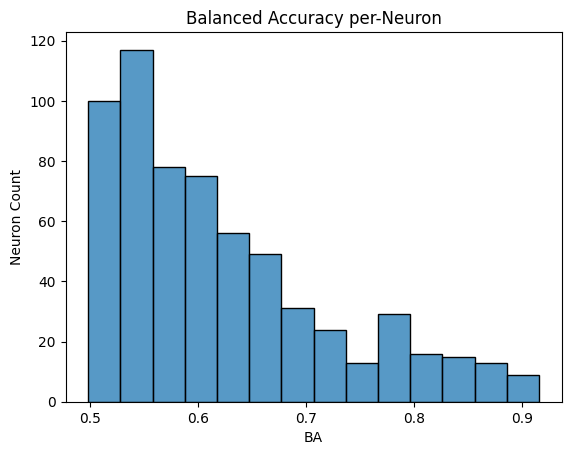

In [96]:
p = sb.histplot(data=neuron_report, x="BA")
_ = p.set(title="Balanced Accuracy per-Neuron", ylabel="Neuron Count")

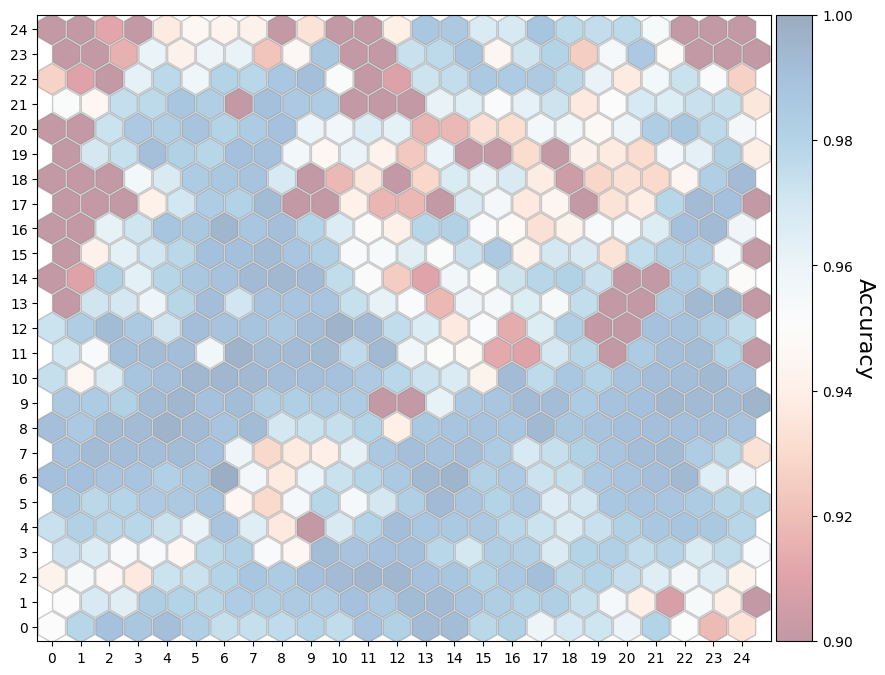

In [103]:
from matplotlib import colors, cm

norm = colors.Normalize(vmin=0.90, vmax=1.00)
p = laytr.make_hex_plot(som, hue=acc_matrix, hue_label="Accuracy", color_map=cm.RdBu, color_norm=norm)

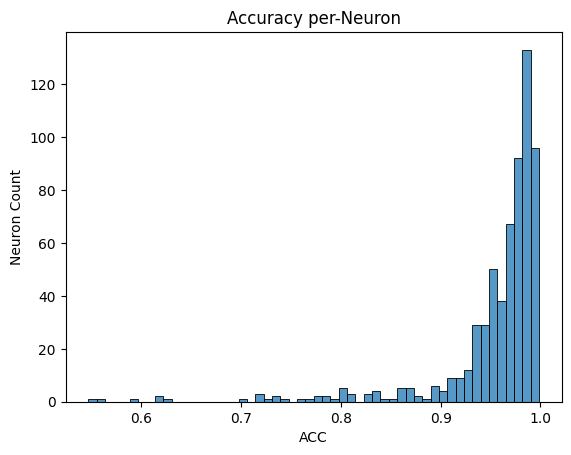

In [102]:
p = sb.histplot(data=neuron_report, x="ACC")
_ = p.set(title="Accuracy per-Neuron", ylabel="Neuron Count")

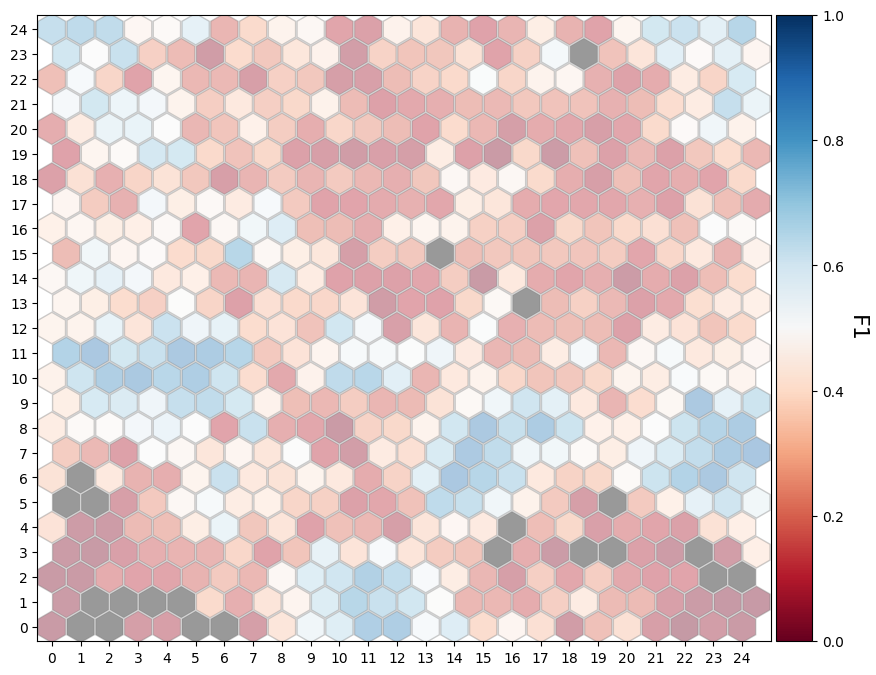

In [106]:
p = laytr.make_hex_plot(som, hue=f1_matrix, hue_label="F1", color_map=cm.RdBu)

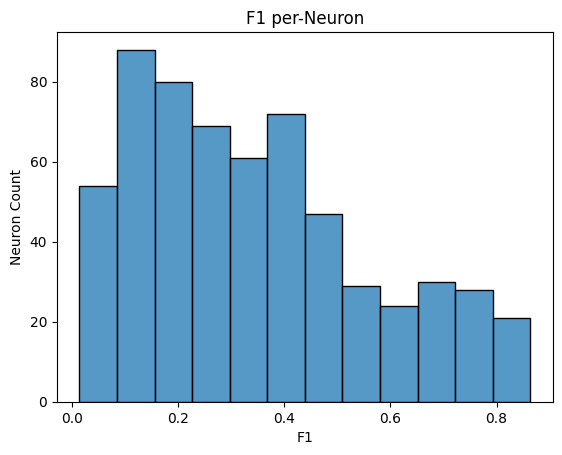

In [105]:
p = sb.histplot(data=neuron_report, x="F1")
_ = p.set(title="F1 per-Neuron", ylabel="Neuron Count")